In [5]:
# General Libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns


# My Modules
import shap as shap
from wilkeXAI.data_generator import DataGenerator
import wilkeXAI.wilke_shap as fwg
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [6]:
def eom(u, t, params = {}):
    """
        Duffing Oscillator Equation of Motion

        ddx + delta * dx**2 + alpha * x + beta * x**3 = gamma * cos(omega * t)

        Input
        ----------
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        alpha : float, linear stiffness
        beta  : float, non linearity in the restoring force
        gamma : float, amplitude of the periodic driving force
        delta : float, amount of damping
        omega : float, angular frequency of the periodic driving force

        Returns
        ----------
        [dx,ddx] : Tuple, Time derivatives of 
                    position and velocity at time t

    """
    x, dx = u[0], u[1]
    ddx = (0.37 * np.cos(1.2 * t) - (1 * dx + (-1) * x + 1 * x**3))

    return [dx,ddx]

In [16]:
def generate(num_samples = int(5e1), delay=3, samples=10, end_time=100):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
        
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays
        parameter_length = 1
        labels = ['xt','vt']
        features = ['x0','v0','t','rand']
        X = np.empty((num_samples*(samples-delay), len(features)))
        y = np.empty((num_samples*(samples-delay), len(labels)))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = [int(100/samples*i) for i in range(samples)][delay:]
        #Generate num_samples samples
        for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
            #Generate random starting positions
            x0 = (x_max - x_min) * np.random.random_sample() + x_min
            v0 = (v_max - v_min) * np.random.random_sample() + v_min 
            #Generate a trajectory
            trajectory = odeint(eom, [x0,v0], t_range)
            for j, t_ind in enumerate(t_vals):
                X[j+i*(samples-delay),:] = [x0, v0, t_range[t_ind], np.random.sample()]
                y[j+i*(samples-delay),:] = trajectory[t_ind,:]      
                                    
        X_df = pd.DataFrame(X, columns = features)
        y_df = pd.DataFrame(y, columns = labels)
        return X_df, y_df, features, labels

# MCMC Shap

In order to get an estimate of the confidence of the shapley values we use Markov Chain Monte Carlo to sample Shapley Values.



In [17]:
suffix = "aaahhh"

In [18]:
X, y, features, labels = generate(num_samples = int(1e3))

Generating Data…: 100%|████████████████| 1000/1000 [00:12<00:00, 80.45it/s]


In [19]:
X

,x0,v0,t,rand
0,-0.723528,-1.380154,30.0,0.465530
1,-0.723528,-1.380154,40.0,0.762741
2,-0.723528,-1.380154,50.0,0.627885
3,-0.723528,-1.380154,60.0,0.210002
4,-0.723528,-1.380154,70.0,0.348169
...,...,...,...,...
6995,0.454850,-0.117024,50.0,0.023087
6996,0.454850,-0.117024,60.0,0.148729
6997,0.454850,-0.117024,70.0,0.527733
6998,0.454850,-0.117024,80.0,0.365999


In [22]:
scaler = MinMaxScaler(feature_range=[-2,2])

X_data = pd.DataFrame(scaler.fit_transform(X), columns=features)

In [32]:
def true_predict(X):
    if type(X) == pd.core.frame.DataFrame:
        X = pd.DataFrame(scaler.inverse_transform(X.values), columns=X.columns)
    elif type(X) == np.ndarray:
        X = pd.DataFrame(scaler.inverse_transform(X), columns=features)
    
    y = np.ones((np.shape(X)[0], 2))
    for i in range(0,np.shape(X)[0]):
        t_range = np.linspace(0, X['t'].iloc[i], 100, endpoint=True)
        y[i,:] = odeint(eom, [X['x0'].iloc[i], X['v0'].iloc[i]], t_range)[-1]
    return y   

In [66]:
class AnalyticExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            if first_run:
                self.__atts = grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                        
        return self.__atts
    

In [34]:
background = shap.sample(X_data, 100)

In [35]:
shap_explainer = shap.KernelExplainer(true_predict, background)

In [36]:
X_sorted = X_data.sort_values(by=['x0'])

choice = X_sorted.iloc[np.sort(np.random.choice(X_sorted.shape[0], 100, replace =False))]

In [83]:
choice

,x0,v0,t,rand
1174,-1.974233,-0.172697,1.333333,0.991812
6188,-1.957521,-1.744738,-2.000000,-0.411688
5233,-1.940970,-0.473676,0.666667,-1.099983
4296,-1.921067,-1.781492,1.333333,-1.188282
6707,-1.892629,0.922252,-1.333333,-0.900527
...,...,...,...,...
4029,1.805298,-1.410698,0.666667,0.925278
2874,1.809280,-0.448072,0.666667,0.879722
551,1.846335,-1.537054,1.333333,0.400772
2320,1.851709,1.962573,0.000000,1.811947


In [39]:
X_shap_values = shap_explainer.shap_values(choice)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
X_shap_values

[array([[-0.59946123, -0.50577293,  0.28035683,  0.        ],
        [ 0.69230555,  0.08737319, -0.26972535,  0.        ],
        [-0.62726564, -0.46030196,  0.18218379,  0.        ],
        [ 0.63762317,  0.13141695,  0.28154211,  0.        ],
        [-0.92919894, -0.18978353, -0.25239554,  0.        ],
        [-0.06525329,  0.83402497,  0.28181057,  0.        ],
        [-0.84989798, -0.26473097, -0.27868617,  0.        ],
        [-0.13122533,  0.90002319,  0.28178437,  0.        ],
        [-0.35570846,  1.12436264,  0.28192806,  0.        ],
        [-0.52900591, -0.58584973,  0.29458096,  0.        ],
        [-0.67127126, -0.44456474,  0.29556132,  0.        ],
        [-0.6565231 , -0.43529012,  0.18642945,  0.        ],
        [-0.88672935, -0.20229455,  0.03342452,  0.        ],
        [-0.94420059, -0.16934695, -0.27977128,  0.        ],
        [-1.20696059,  0.10375688, -0.13282556,  0.        ],
        [-1.09034484,  0.00213929,  0.18282178,  0.        ],
        

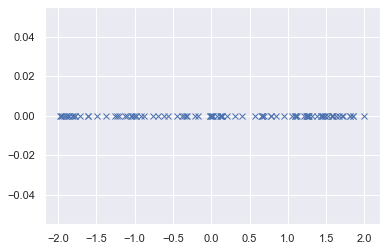

In [47]:
plt.plot(choice['x0'], X_shap_values[0][:,3],'x')

In [48]:
lime_explainer = shap.other.LimeTabular(true_predict, background, mode="regression")

In [49]:
X_lime_values = lime_explainer.attributions(choice)

Text(0, 0.5, 'Feature Contribution [ ]')

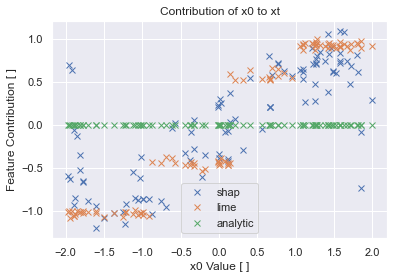

In [75]:
plt.plot(choice['x0'], X_shap_values[1][:,0],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,0],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,0],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of x0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')



Text(0, 0.5, 'Feature Contribution [ ]')

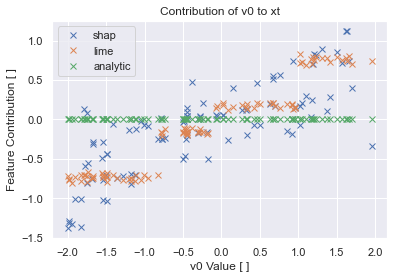

In [76]:
plt.plot(choice['v0'], X_shap_values[0][:,1],' x', label = 'shap')
plt.plot(choice['v0'], X_lime_values[0][:,1],' x', label = 'lime')
plt.plot(choice['v0'], X_anal_values[0][:,1],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of v0 to xt')
plt.xlabel('v0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

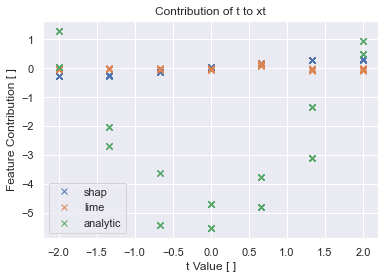

In [77]:
plt.plot(choice['t'], X_shap_values[0][:,2],' x', label = 'shap')
plt.plot(choice['t'], X_lime_values[0][:,2],' x', label = 'lime')
plt.plot(choice['t'], X_anal_values[0][:,2],' x', label = 'analytic')

plt.legend()
plt.title('Contribution of t to xt')
plt.xlabel('t Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

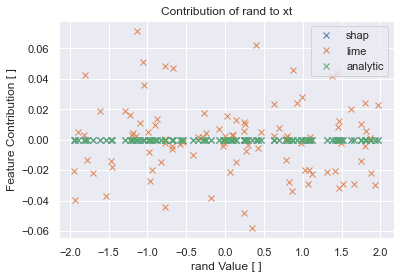

In [78]:
plt.plot(choice['rand'], X_shap_values[0][:,3],' x', label = 'shap')
plt.plot(choice['rand'], X_lime_values[0][:,3],' x', label = 'lime')
plt.plot(choice['rand'], X_anal_values[0][:,3],' x', label = 'analytic')

plt.legend()
plt.title('Contribution of rand to xt')
plt.xlabel('rand Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

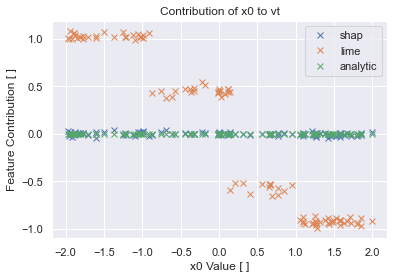

In [79]:
plt.plot(choice['x0'], X_shap_values[1][:,0],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,0],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,0],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of x0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


Text(0, 0.5, 'Feature Contribution [ ]')

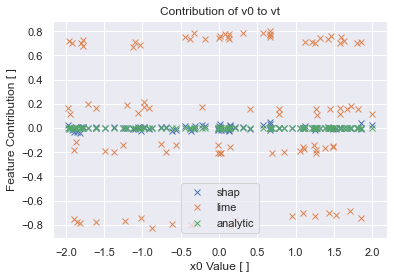

In [80]:
plt.plot(choice['x0'], X_shap_values[1][:,1],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,1],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,1],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of v0 to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


Text(0, 0.5, 'Feature Contribution [ ]')

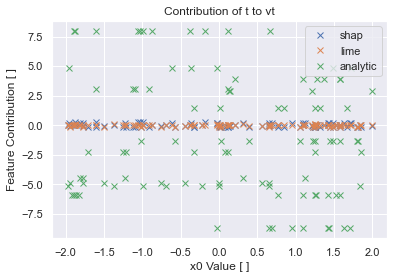

In [81]:
plt.plot(choice['x0'], X_shap_values[1][:,2],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,2],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,2],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of t to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')

Text(0, 0.5, 'Feature Contribution [ ]')

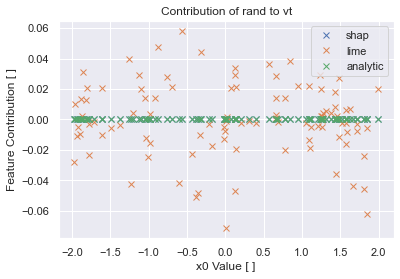

In [82]:
plt.plot(choice['x0'], X_shap_values[1][:,3],' x', label = 'shap')
plt.plot(choice['x0'], X_lime_values[1][:,3],' x', label = 'lime')
plt.plot(choice['x0'], X_anal_values[1][:,3],' x', label = 'analytic')
plt.legend()
plt.title('Contribution of rand to vt')
plt.xlabel('x0 Value [ ]')
plt.ylabel('Feature Contribution [ ]')


In [67]:
anal_explainer = AnalyticExplainer(true_predict, ['x0','v0','t','rand'], ['xt', 'vt'],  h=0.01)

In [69]:
X_anal_values = anal_explainer.feature_att(choice)

In [84]:
X_anal_values

[array([[ 3.75355935e-07,  3.40701900e-07, -1.32757120e+00,
          0.00000000e+00],
        [ 2.08829627e-04,  4.01948625e-05,  2.95714397e-02,
          0.00000000e+00],
        [-1.62890520e-06,  1.40849474e-06, -3.76009888e+00,
          0.00000000e+00],
        [-3.55304319e-07, -1.34144491e-06, -3.10850934e+00,
          0.00000000e+00],
        [-7.58069386e-06,  1.32270156e-06, -2.70141242e+00,
          0.00000000e+00],
        [-5.41987288e-07,  1.93011751e-07, -3.10850713e+00,
          0.00000000e+00],
        [-3.78359852e-05,  2.97019931e-06,  1.30298370e+00,
          0.00000000e+00],
        [-2.56759536e-07,  1.34606171e-07, -3.10850846e+00,
          0.00000000e+00],
        [-6.22909946e-07, -7.45602435e-07, -3.10850949e+00,
          0.00000000e+00],
        [ 8.93203078e-07, -9.12490816e-07,  9.62604407e-01,
          0.00000000e+00],
        [-1.32471894e-06, -1.37871869e-07,  9.62605134e-01,
          0.00000000e+00],
        [-4.22146368e-07, -2.57999927e-07, 

In [ ]:
def gridded_data(feature='x0', X, features = ['x0','v0','t','rand']):
    feat_min = min(X[feature])
    feat_max = max(X[feature])
    
    feat_range = np.linspace(feat_min, feat_max, 100)
    data = np.empty((100,len(features)))
    for k in features:
        data[:,k] = np.ones((100,1))*np.mean(X[k])
    
        
    data = pd.DataFrame(data, columns = features)
    for i, val in enumerate(feat_range):
        data[feature][i] = val
        
    return data


In [47]:
shap_exp.eval_explainer()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,,,,x0,v0,t,rand,alpha,beta,gamma,delta,omega
num,feature,contribution,model,,,,,,,,,
0,x0,xt,ml,0.974175,0.009153,0.319542,0.0,0.0,0.0,0.0,0.0,0.0
1,x0,xt,ml,0.881571,0.094095,0.231594,0.0,0.0,0.0,0.0,0.0,0.0
2,x0,xt,ml,0.886235,0.094706,0.283503,0.0,0.0,0.0,0.0,0.0,0.0
3,x0,xt,ml,0.975932,-0.000095,0.231423,0.0,0.0,0.0,0.0,0.0,0.0
4,x0,xt,ml,-0.427818,-0.482664,0.268088,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,omega,vt,ml,0.017997,0.017619,-0.114530,0.0,0.0,0.0,0.0,0.0,0.0
96,omega,vt,ml,0.021289,-0.000377,0.245801,0.0,0.0,0.0,0.0,0.0,0.0
97,omega,vt,ml,0.013871,0.029744,0.177137,0.0,0.0,0.0,0.0,0.0,0.0
